<a href="https://colab.research.google.com/github/ISL-0111/XAI_AIPI590.01_2025Fall/blob/main/Week4_machine_learning_court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb)

# 👩‍⚖️ ⚖️ Machine Learning Court

This notebook provides base model training code for our three case scenarios:
1. **Loan Approval**
2. **Breast Cancer Misclassification**
3. **Recidivism Prediction**

> ⚠️ This notebook does **not** include XAI techniques (SHAP, LIME, Anchors). You are expected to implement those yourself based on the model and prediction tasks below.

## ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 [V] Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 [ ]Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

In [ ]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))


              precision    recall  f1-score   support

           0       0.67      0.68      0.68       823
           1       0.57      0.56      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [ ]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)

Prediction for Malik Johnson (Recidivism): [0]


Data Exploration

In [ ]:
display(df.head())
display(df['c_charge_degree'].unique()) # Binary Felony(F) or Not = Misdemeanor(M)

,age,sex,race,priors_count,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,two_year_recid
0,69,1,5,0,0,0,0,0,0
1,34,1,0,0,0,0,0,0,1
2,24,1,0,4,0,0,1,0,1
3,23,1,0,1,0,1,0,0,0
4,43,1,5,2,0,0,0,0,0


array([0, 1], dtype=int8)

#### Model Performance Analysis & Research Approach

Given recidivism prediction model shows an overall accuracy of 63%, but this metric can be misleading due to class imbalance (823 non-recidivists vs. 620 recidivists). Moreover, the performance metrics raised concerns. For the 620 actual recidivists in our test set, the model only achieves a recall of 0.56, meaning approximately 347 true positives but **273 false negatives** - that's 273 actual recidivists who were incorrectly classified as low risk. On the other hand, for the 823 actual non-recidivists, the recall is 0.68, resulting in about 562 true negatives and 261 false positives.

To investigate whether Malik Johnson's case represents this underestimation problem, I'll use two local explanation methods.
- First, **SHAP Analysis** will explain which features contributed to Malik's low-risk prediction and how strongly they influenced the decision.

- Second, **Counterfactual Analysis** will reveal whether minimal, realistic changes to Malik's profile could flip his classification from low-risk to high-risk.

#### SHAP Analysis
Because I focus on class 1 ("high risk of recidivism"), positive SHAP values push the prediction toward higher recidivism probability, while negative values act as protective factors that reduce the predicted risk.

**Malik's Individual Feature Contributions**<br>
The model assigned Malik a recidivism probability of 0.124 (12.4%), classifying him as low-risk(<0.5). This reflects his baseline risk (the average prediction across all cases) plus his individual feature-level contributions:

**Risk-Increasing Factor:**<br>
- `sex = +0.014`: Being male slightly increases his predicted risk

**Protective Factors:**<br>
- `priors_count = -0.149`: Having only 1 prior conviction provides strong protection compared to the average
- `c_charge_degree = -0.075`: His current charge degree codes as lower risk in the model's decision trees
- `race = -0.045`: His encoded race value routes him toward lower-risk leaf nodes
- `age = -0.014`: At 27, he's slightly protected (older age typically correlates with lower recidivism)
- Juvenile record factors (all zeros): `juv_other_count = -0.014`, `juv_fel_count = -0.006`, `juv_misd_count = -0.001`

**Insights**<br>
Most of Malik's characteristics are protective, the **magnitudes are small**. This suggests his case is near the decision boundary with limited margin. In other words, Malik's case relies on the cumulative effect of several weak protective factors rather than any single strong predictor. Additionally, Random Forest models are non-monotonic, meaning small changes can bring abrupt increase the predicted probability.

*Note1: Globally, priors and age are the main levers. Malik has just one priors and is not old, so his protective cushion is small*<br>
*Note2: Race is categorical and could be one-hot-encoded for better interpretability, but since it represents an inherent personal characteristic that cannot be ethically altered in counterfactual scenarios, I maintain the original label encoding for consistency with the experimental constraints.*


=== SHAP: Local contributors toward HIGH risk (top positives) ===
sex                0.014064
juv_misd_count    -0.001061
juv_fel_count     -0.006094
juv_other_count   -0.013957
age               -0.014416
race              -0.044499
c_charge_degree   -0.075079
priors_count      -0.148845
dtype: float64

=== SHAP: Strongest protective factors (most negative) ===
sex                0.014064
juv_misd_count    -0.001061
juv_fel_count     -0.006094
juv_other_count   -0.013957
age               -0.014416
race              -0.044499
c_charge_degree   -0.075079
priors_count      -0.148845
dtype: float64


 99%|===================| 2854/2886 [00:55<00:00]        

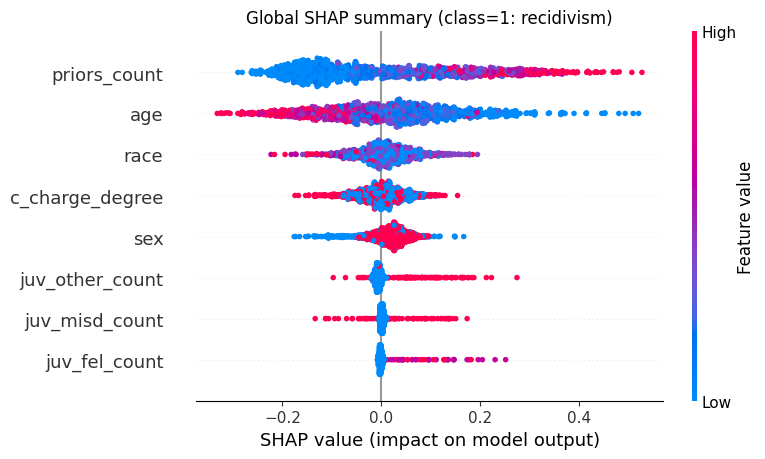

In [ ]:
'''
The below code snippet was generated using GPT5 on Sep/22/25 at 19:00
'''
# ===== SHAP: Local + Global explanations for Malik (robust) =====
import shap, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Ensure Malik’s column order matches the model
focus_x = focus_instance_compas[model_compas.feature_names_in_]

# Build a stable explainer (probability space + background data)
explainer = shap.TreeExplainer(
    model_compas,
    data=X_train[model_compas.feature_names_in_],
    model_output="probability"
)

# Compute SHAP for Malik
shap_values = explainer.shap_values(focus_x)
base_values = explainer.expected_value

def get_class1_vector(shap_values, base_values, sample_idx=0, class_idx=1):
    """
    Return (vec_1d, base_class1) for class=1, handling:
    - list per class
    - (n_samples, n_features)
    - (n_samples, n_features, n_classes)
    """
    if np.size(base_values) > 1:
        base_class1 = float(base_values[class_idx])
    else:
        base_class1 = float(base_values)

    if isinstance(shap_values, list):
        vec = shap_values[class_idx][sample_idx, :]
    else:
        sv = np.asarray(shap_values)
        if sv.ndim == 3:
            vec = sv[sample_idx, :, class_idx]
        elif sv.ndim == 2:
            vec = sv[sample_idx, :]
        else:
            raise ValueError(f"Unexpected SHAP array ndim={sv.ndim}")
    return vec, base_class1

vec1, base_class1 = get_class1_vector(shap_values, base_values, sample_idx=0, class_idx=1)

# Local ranking (positive → pushes toward HIGH risk; negative → protective)
local_series = pd.Series(vec1, index=focus_x.columns).sort_values(ascending=False)
print("\n=== SHAP: Local contributors toward HIGH risk (top positives) ===")
print(local_series.head(10))
print("\n=== SHAP: Strongest protective factors (most negative) ===")
print(local_series.tail(10))

# Optional visuals (best in notebooks)
shap.initjs()
try:
    from IPython.display import display
    display(shap.force_plot(base_class1, vec1, focus_x.iloc[0, :]))
except Exception as e:
    print("[Note] force_plot not shown:", e)

# ---- Global summary (optional; recompute on X_test) ----
def get_class1_matrix(sv, class_idx=1):
    if isinstance(sv, list):
        return sv[class_idx]            # (n_samples, n_features)
    arr = np.asarray(sv)
    if arr.ndim == 3:
        return arr[:, :, class_idx]     # (n_samples, n_features)
    elif arr.ndim == 2:
        return arr                      # (n_samples, n_features)
    else:
        raise ValueError(f"Unexpected ndim={arr.ndim}")

try:
    sv_test = explainer.shap_values(X_test[model_compas.feature_names_in_])
    sv_test_class1 = get_class1_matrix(sv_test, class_idx=1)
    shap.summary_plot(sv_test_class1, X_test[model_compas.feature_names_in_], show=False)
    plt.title("Global SHAP summary (class=1: recidivism)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("[Note] summary_plot not shown:", e)


#### Counterfactual Analysis

I conduct a **Counterfactual Analysis** to test whether minimal, realistic changes to Malik's profile could flip his classification from low-risk to high-risk, demonstrating the fragility of the model's prediction.

**Features:**
- Fixed(immutable personal traints): `race`, `sex`, `age`
- Editable(onluy +1 increments): `priors_count`, `juv_fel_count`, `juv_misd_count`, `juv_other_count`
- Categorical(single flip): `c_charge_degree` (1→0)

**Objectives:**
- Identify minimal changes that push P(recidivism) ≥ 0.5 (high-risk threshold)
- Test whether 1-2 feature modifications can flip the "low-risk" to "high-risk" classification

**Insights**
- One minimal, realistic change (e.g., a single juvenile offense recorded) crosses 0.50. Multiple two-edit paths far exceed the threshold.
- Minimal edits on count features (+1), with race/sex/age fixed (k=1..2):
    - k=1<br>
        - juv_fel_count 0→1 → 0.597 (flips to high risk)<br>
        - juv_misd_count 0→1 → 0.522 (flips to high risk)<br>
    - k=2<br>
        - priors_count 1→2 + juv_fel_count 0→1 → 0.765<br>
        - juv_fel_count 0→1 + juv_other_count 0→1 → 0.742<br>
        - priors_count 1→2 + juv_misd_count 0→1 → 0.681<br>
        - juv_fel_count 0→1 + juv_misd_count 0→1 → 0.655<br>
        - juv_misd_count 0→1 + juv_other_count 0→1 → 0.502<br>

- A single +1 to juvenile felony or juvenile misdemeanor already crosses the 0.50 bar, supporting decision fragility around Malik’s current profile.
- Multiple two-edit paths exceed the threshold by wide margins (up to 0.765), confirming that Malik’s low-risk label sits near a thin safety margin.

In [ ]:
'''
The below code snippet was generated using GPT5 on Sep/22/25 at 20:10
'''

import pandas as pd
from itertools import product, combinations

COUNT_FEATURES = ["priors_count","juv_fel_count","juv_misd_count","juv_other_count"]
IMMUTABLE      = {"race","sex","age"}    # age now fixed
orig           = focus_x.iloc[0].copy()

def build_grids_plus1_counts_only(orig_row, X_train):
    """Only allow +1 changes on count features; age & c_charge_degree stay fixed for combos."""
    grids = {}
    for f in COUNT_FEATURES:
        v0 = int(orig_row[f]); vmax = int(X_train[f].max())
        grids[f] = [v0+1] if v0+1 <= vmax else []
    return grids

def to_df_row(series_like):
    return pd.DataFrame([series_like], columns=model_compas.feature_names_in_)

def sanitize_counts(row):
    for f in COUNT_FEATURES:
        row[f] = int(max(0, round(row[f])))

def enumerate_plus1_counts_threshold(orig_row, grids, model, threshold=0.5, max_changes=2, top_k=30):
    """Counts-only +1; collect candidates with P1 >= threshold, sort by P1 desc (age fixed)."""
    rows = []
    feats = [f for f, vals in grids.items() if vals and f not in IMMUTABLE]
    for k in range(1, max_changes+1):
        for comb in combinations(feats, k):
            vals = [grids[f][0] for f in comb]  # +1 for each selected count
            chg = {f: v for f, v in zip(comb, vals) if v != orig_row[f]}
            if not chg:
                continue
            cand = orig_row.copy()
            for f, v in chg.items():
                cand[f] = v
            sanitize_counts(cand)
            for f in IMMUTABLE:
                cand[f] = orig_row[f]
            p1 = model.predict_proba(to_df_row(cand))[0, 1]
            if p1 >= threshold:
                rows.append({
                    "k": k,
                    "changes": {f: (orig_row[f], cand[f]) for f in chg},
                    "P1": round(p1, 3)
                })
    if not rows:
        return pd.DataFrame(columns=["k","changes","P1"])
    return pd.DataFrame(rows).sort_values(["P1","k"], ascending=[False, True]).head(top_k)

# ---- Run
grids_p1 = build_grids_plus1_counts_only(orig, X_train)

# Original P1
p1_orig = model_compas.predict_proba(pd.DataFrame([orig], columns=model_compas.feature_names_in_))[:,1][0]
print(f"Original P1 = {p1_orig:.3f}")

# (A) Single-edit probe for c_charge_degree (flip 1<->0), reported regardless of threshold
d0 = int(orig["c_charge_degree"])
d1 = 1 - d0
cand_deg = orig.copy()
cand_deg["c_charge_degree"] = d1
sanitize_counts(cand_deg)
for f in IMMUTABLE:
    cand_deg[f] = orig[f]
p1_deg = model_compas.predict_proba(to_df_row(cand_deg))[0,1]
print(f"Single edit — c_charge_degree {d0}->{d1}: P1 = {p1_deg:.3f}")

# (B) Counts-only +1 combos (k=1..2) at threshold 0.50 (same behavior as before)
top_plus1 = enumerate_plus1_counts_threshold(orig, grids_p1, model_compas, threshold=0.5, max_changes=2, top_k=30)
print("\nTop candidates (ONLY +1 on count features; race/sex/age fixed; P1 >= 0.5):")
print(top_plus1.to_string(index=False))


Original P1 = 0.124
Single edit — c_charge_degree 1->0: P1 = 0.278

Top candidates (ONLY +1 on count features; race/sex/age fixed; P1 >= 0.5):
 k                                               changes    P1
 2     {'priors_count': (1, 2), 'juv_fel_count': (0, 1)} 0.765
 2  {'juv_fel_count': (0, 1), 'juv_other_count': (0, 1)} 0.742
 2    {'priors_count': (1, 2), 'juv_misd_count': (0, 1)} 0.681
 2   {'juv_fel_count': (0, 1), 'juv_misd_count': (0, 1)} 0.655
 1                             {'juv_fel_count': (0, 1)} 0.597
 1                            {'juv_misd_count': (0, 1)} 0.522
 2 {'juv_misd_count': (0, 1), 'juv_other_count': (0, 1)} 0.502


- ***Given the model already misses ~273 actual reoffenders, Malik’s label flips to high risk with just one additional count. This provides evidence that his current low-risk classification is fragile and likely reflects systematic underestimation near the decision boundary.***